In [1]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers
from laos_gggi.data_functions.combine_data import load_all_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy

import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load

configure_plot_style()

In [2]:
def load_data(fpath):
    data = pd.read_csv(fpath)
    data['geometry'] = gpd.points_from_xy(data.long, data.lat)
    data = gpd.GeoDataFrame(data, crs='EPSG:4326')
    
    return data

folder = 'data'
modified_data = False
fpath_1 = here(os.path.join(folder, 'disaster_locations_gpt_repaired_w_features.csv'))
fpath_2 = here(os.path.join(folder, 'disaster_locations_gpt_repaired.csv'))
if os.path.exists(fpath_1):
    data = load_data(fpath_1)
elif os.path.exists(fpath_2):
    data = load_data(fpath_2)
else:
    raise ValueError('Go run the GPT notebook first!')

In [3]:
#Load Laos shapefile
laos = load_shapefile('laos')

In [4]:
#Load data
emdat = load_emdat_data()

In [5]:
data = (data
            .set_index(['emdat_index'])
            .join(emdat['df_raw_filtered_adj'])
            .reset_index(drop=False)
            .rename(columns={'index':'emdat_index'})
            .set_index(['emdat_index', 'location_id'])
       )

In [6]:
world = load_shapefile('world')
laos = load_shapefile('laos')
coastline = load_shapefile('coastline')
rivers = load_rivers_data()

C:\Users\camil\AppData\Local\Temp\ipykernel_48372\3914288617.py:4: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  rivers = load_rivers_data()


<Axes: >

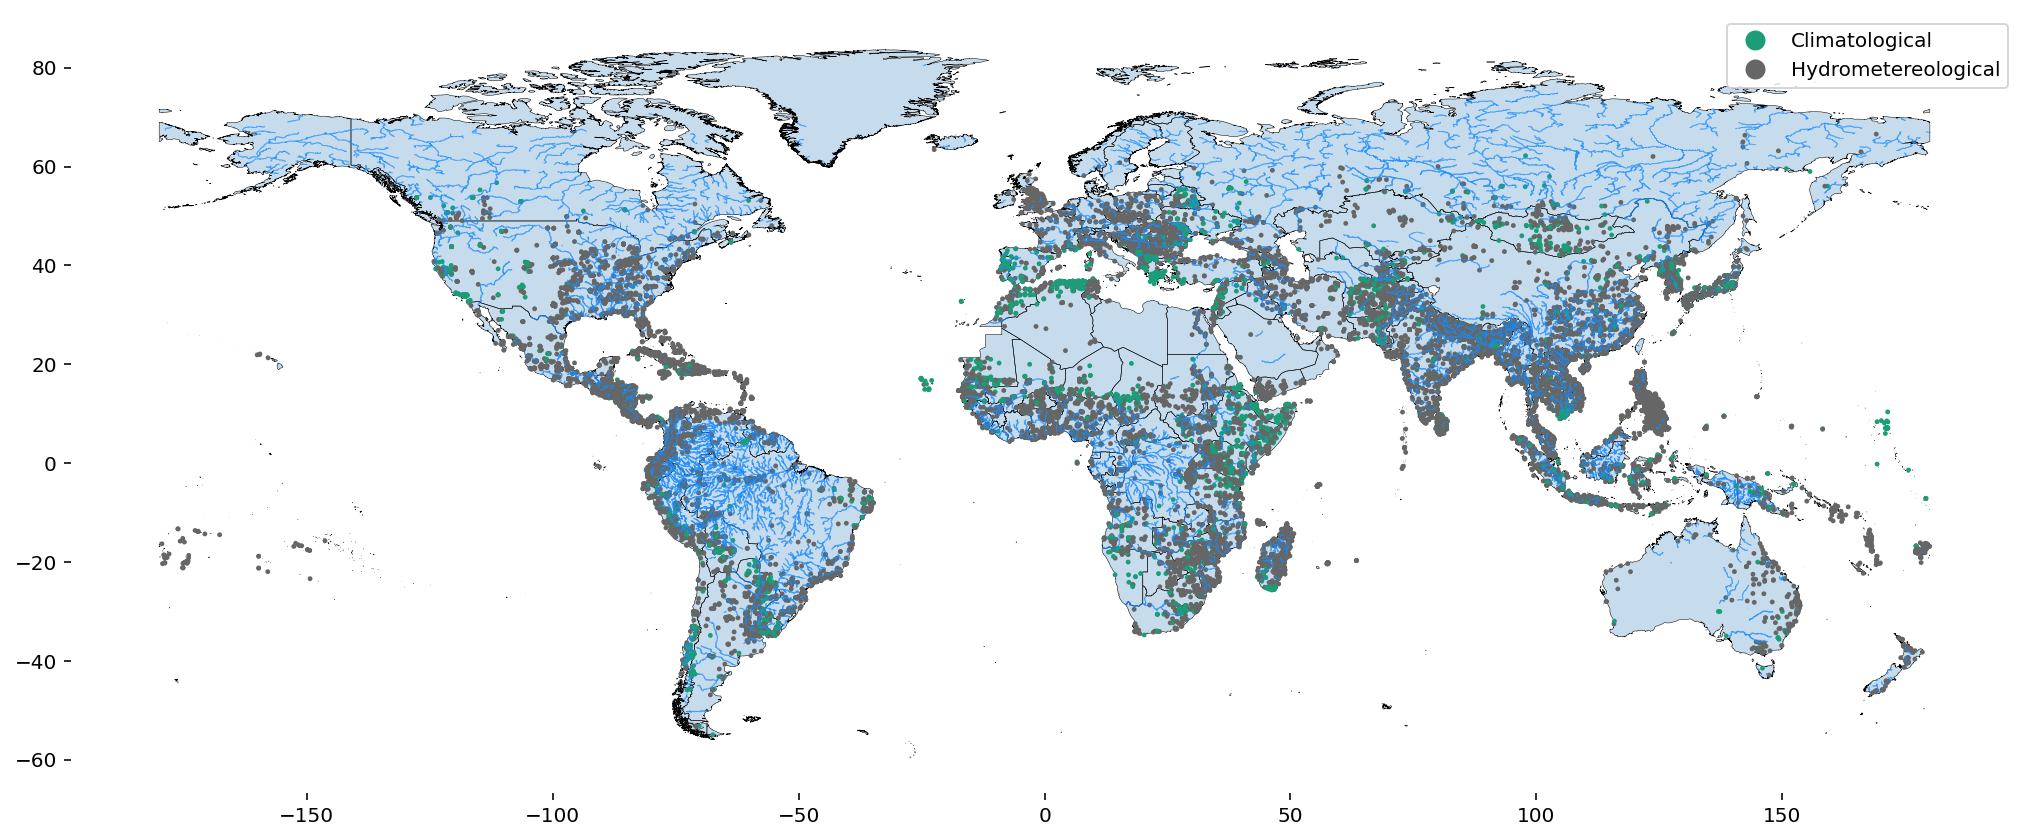

In [7]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('disaster_class', markersize=2, ax=ax, legend=True, cmap='Dark2')

In [8]:
from joblib import Parallel, delayed
import pandas as pd
from tqdm.notebook import tqdm

def get_distance_to(gdf, points, return_columns=None, crs="EPSG:3395", n_cores=-1):
    if return_columns is None:
        return_columns = []
        
    gdf_km = gdf.copy().to_crs(crs)
    points_km = points.copy().to_crs(crs)
    
    def get_closest(idx, row, gdf_km, return_columns):
        series = gdf_km.distance(row.geometry)
        index = series[series == series.min()].index[0]

        ret_vals = (series.min(), )
        for col in return_columns:
            ret_vals += (gdf_km.loc[index][col], )
        
        return ret_vals
    
    with Parallel(n_cores, require='sharedmem') as pool:
        results = pool(delayed(get_closest)(idx, row, gdf_km, return_columns) for idx, row in tqdm(points_km.iterrows(), total=points.shape[0]))
    return pd.DataFrame(results, columns = ['distance_to_closest'] + return_columns, index=points.index)

In [9]:
if 'distance_to_river' not in data.columns:
    distances = get_distance_to(rivers, points=data, return_columns=['ORD_FLOW', 'HYRIV_ID']).rename(columns={'distance_to_closest':'distance_to_river'})
    data = data.join(distances).assign(distance_to_river = lambda x: x.distance_to_river / 1000)
    modified_data = True

<Axes: ylabel='Frequency'>

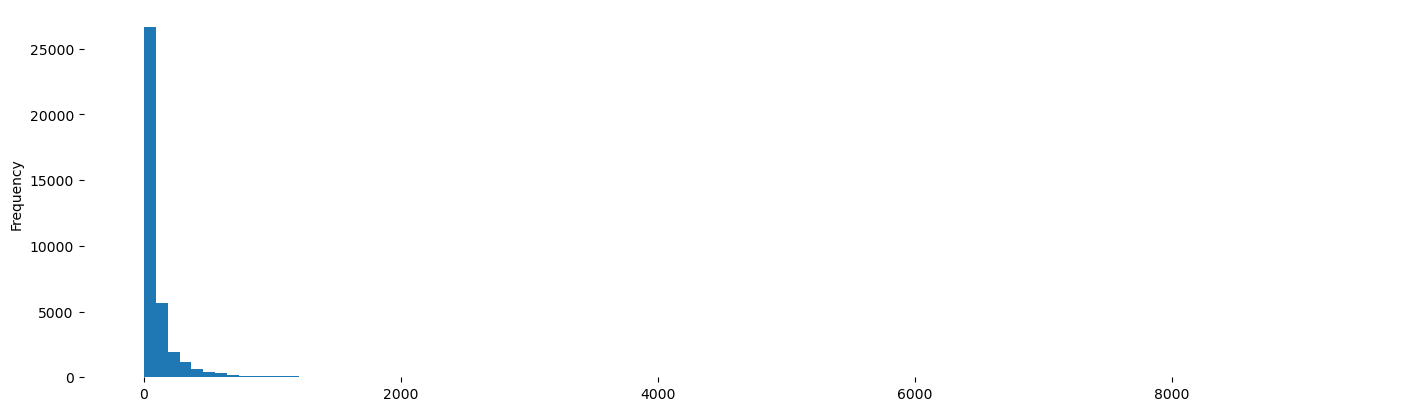

In [10]:
data.distance_to_river.plot.hist(bins=100)

In [11]:
if 'distance_to_coastline' not in data.columns:
    distances = get_distance_to(coastline.boundary, points=data.loc[:, ['geometry']]).rename(columns={'distance_to_closest':'distance_to_coastline'})
    data = data.join(distances).assign(distance_to_coastline = lambda x: x.distance_to_coastline / 1000)
    modified_data = True

<Axes: ylabel='Frequency'>

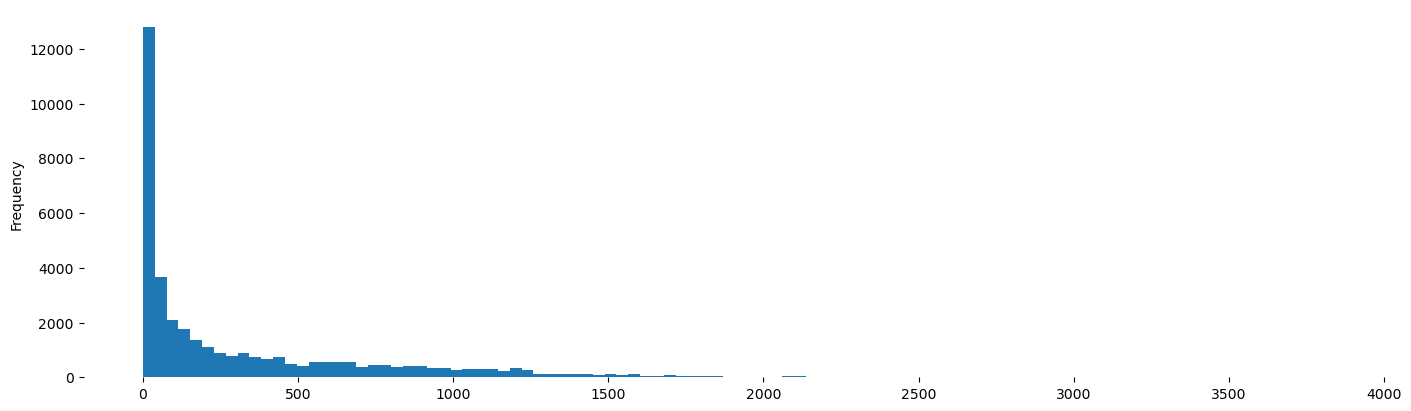

In [12]:
data.distance_to_coastline.plot.hist(bins=100)

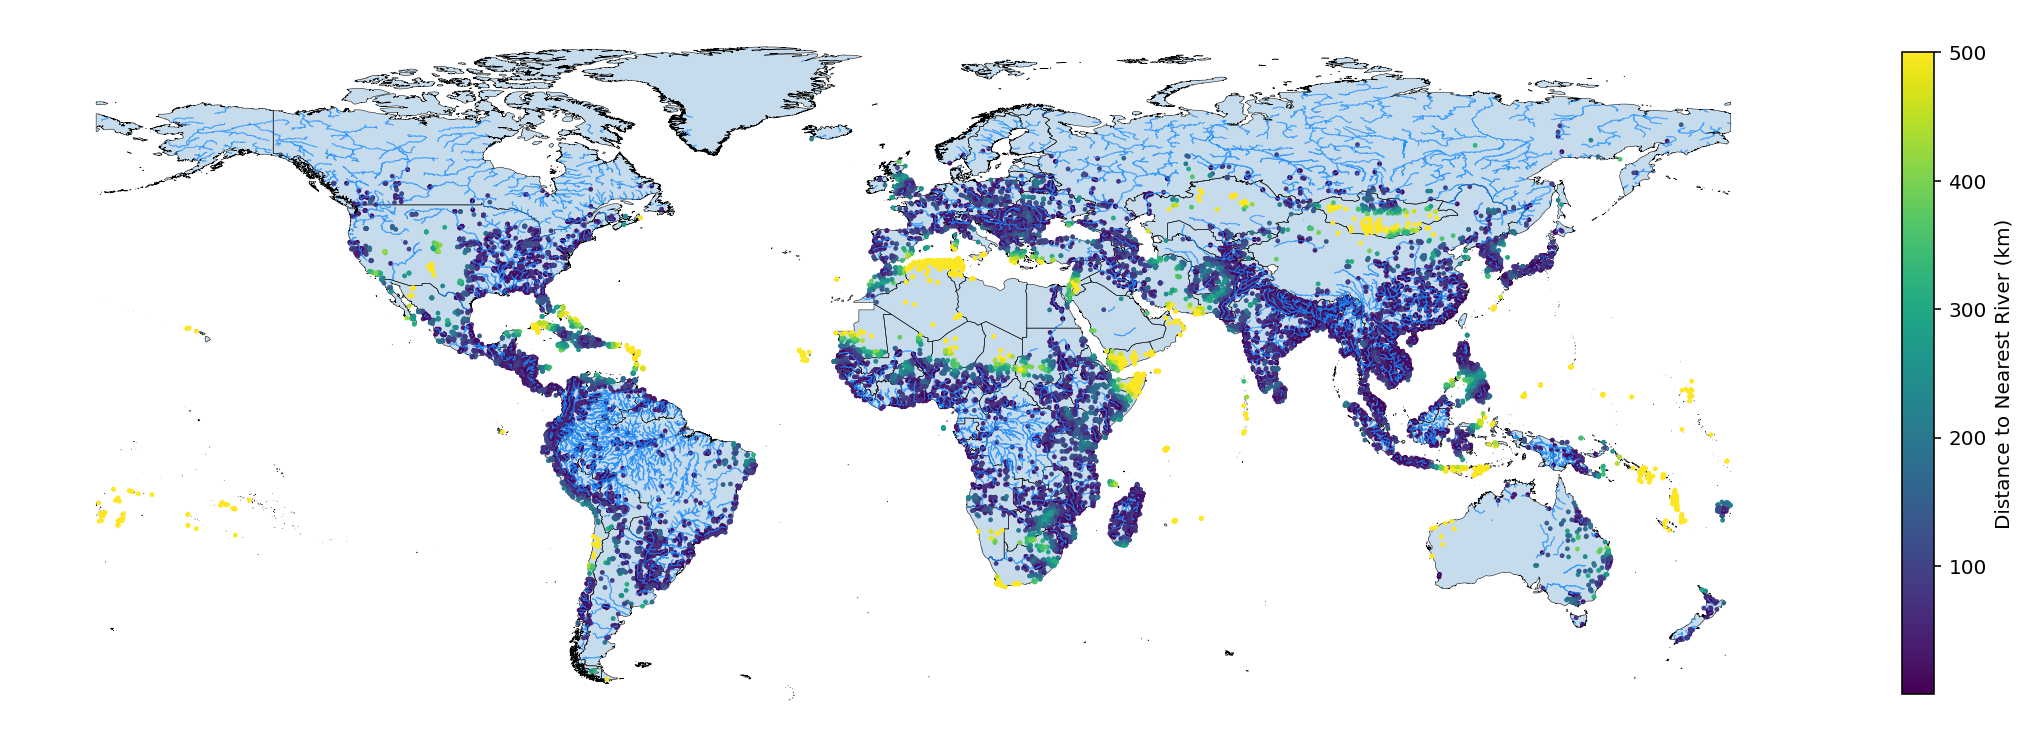

In [13]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_river', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500, 
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest River (km)'})
ax.axis('off')
plt.show()

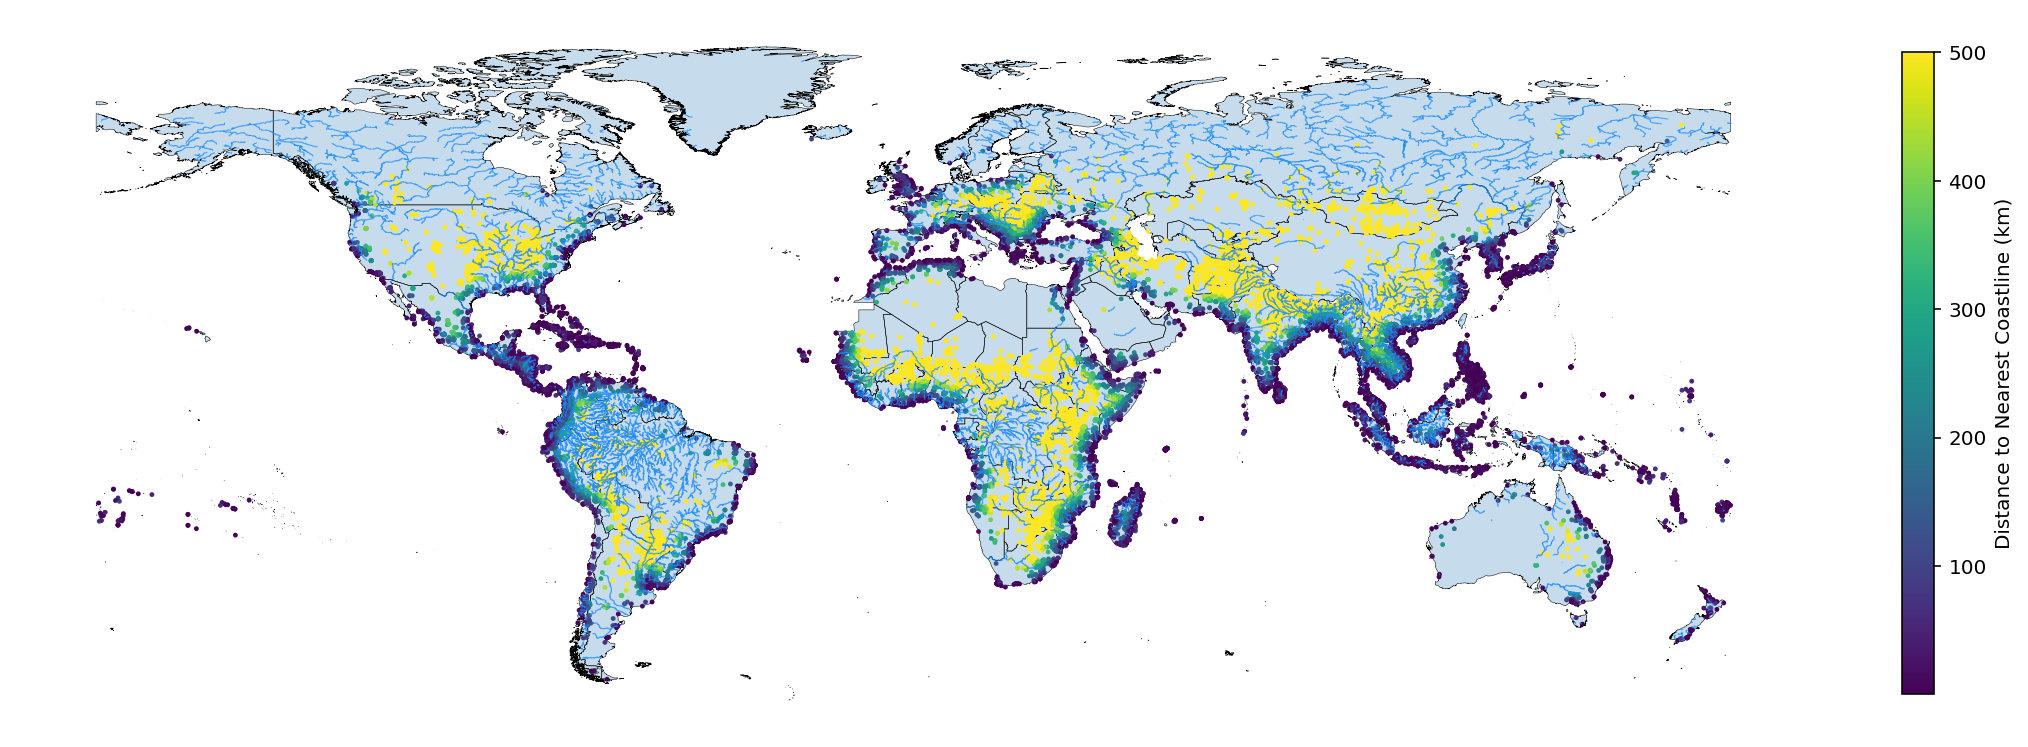

In [14]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_coastline', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500,
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest Coastline (km)'})
ax.axis('off')
plt.show()

In [15]:
if 'is_island' not in data.columns:
    try:
        import wikipedia as wp
    except ImportError:
        !mamba install wikipedia -q -y
        import wikipedia as wp

    html = wp.page("List_of_island_countries").html().encode("UTF-8")
    island_table = (pd.read_html(html, skiprows=0)[0]
                        .droplevel(axis=1, level=0)
                        .dropna(how='all').iloc[1:]
                        .reset_index(drop=True)
                        .assign(ISO_2 = lambda x: x['ISO code'].str.split().str[0],
                                ISO_3 = lambda x: x['ISO code'].str.split().str[1].replace({'or':'GBR'}))
                   )
    data['is_island'] = data.ISO.isin(island_table.ISO_3)
    modified_data = True

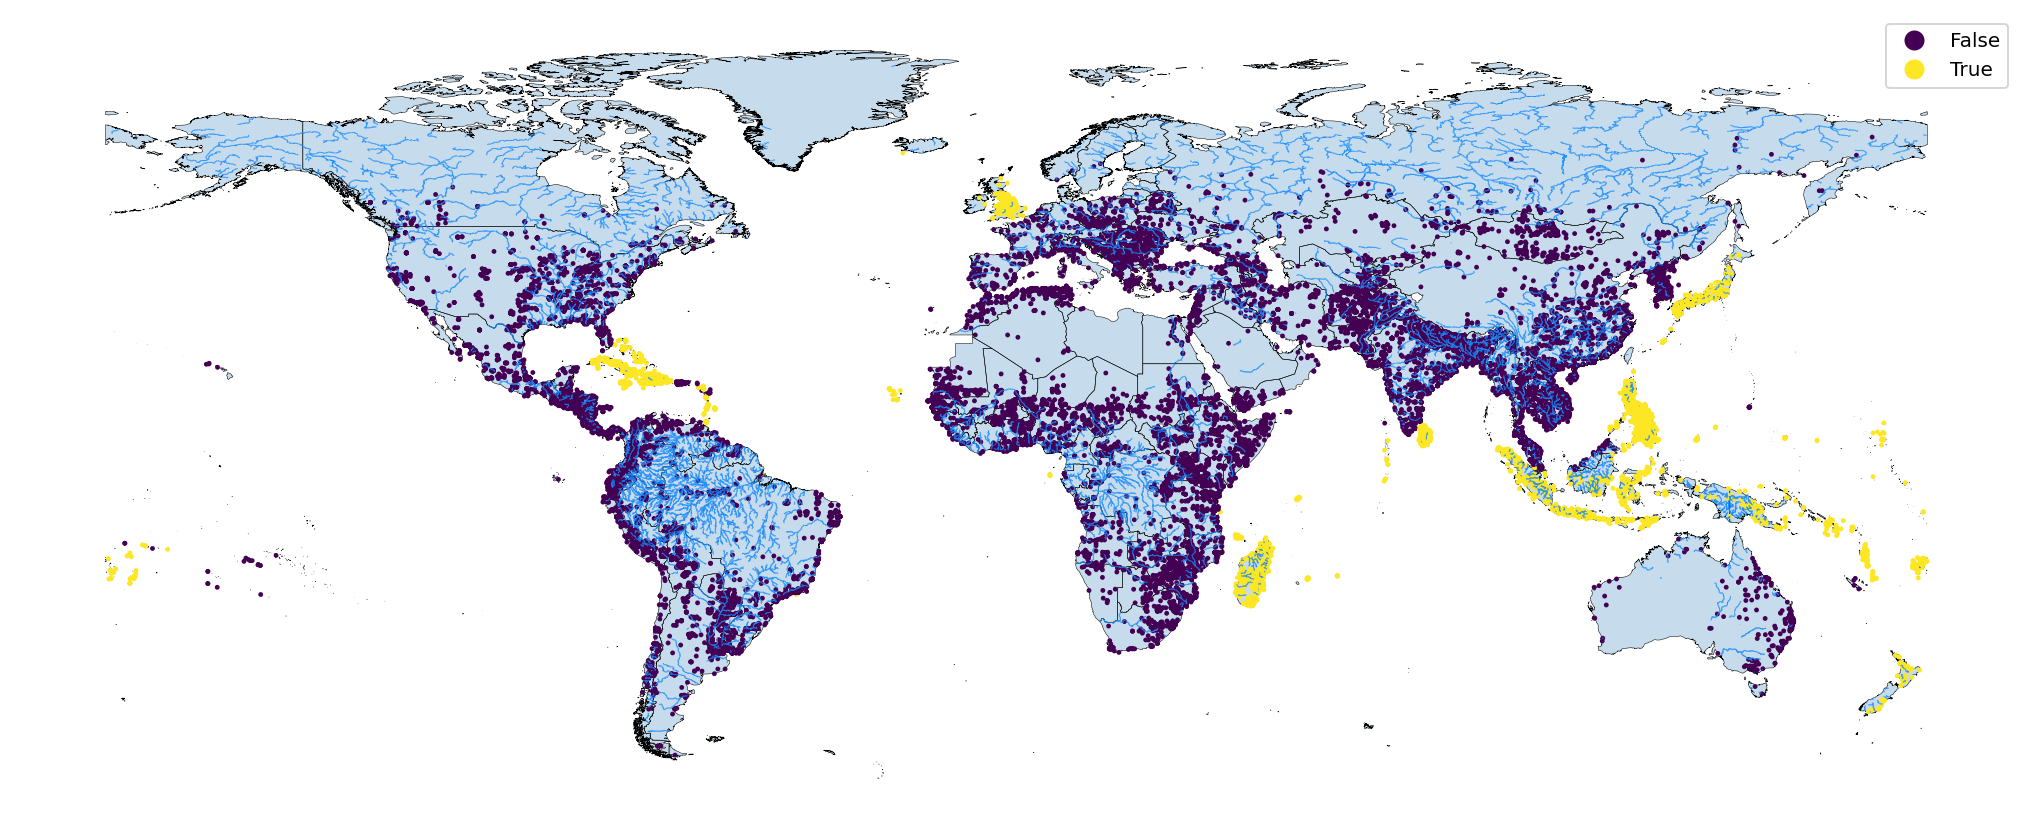

In [16]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

data.dropna(subset='disaster_class').plot('is_island', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.show()

In [17]:
if modified_data:
    (data
         .drop(columns=emdat['df_raw_filtered_adj'].columns.tolist() + ['geometry'])
         .to_csv(fpath_1))

# Synthetic Data

Create a bunch of dummy datapoints with geospatial features. These will be non-disasters. The model will need to distinguish the real disaster data from these fake points.

In [18]:
if not os.path.exists(here('data/synthetic_non_disasters.csv')):
    seed = sum(map(ord, 'Laos GGGI Climate Adaptation'))
    rng = np.random.default_rng(seed)

    # "Melt" the world into 5 regions - Americas, Europe, Asia, Afria, Oceania. This corresponds with the "Regions" column from EMDAT
    simple_world = (world
                        .replace({'North America':'Americas', 'South America':'Americas'})
                        .query('CONTINENT != "Seven seas (open ocean)"')
                        .dissolve('CONTINENT')
                        .loc[data.Region.unique()])

    # For every region, sample a random point for each disaster observed in that region
    not_disasters = (simple_world
                         .sample_points(data.groupby('Region').size().values, rng=rng)
                         .explode()
                         .reset_index()
                         .rename(columns={'CONTINENT':'Region', 'sampled_points':'geometry'})
                         .set_geometry('geometry'))

    # Compute geospatial features for the artifical data
    iso_dicts = [gpd.sjoin(world.loc[[i]], not_disasters, predicate='contains')[['ISO_A3', 'index_right']].set_index('index_right').to_dict()['ISO_A3'] for i in world.index]
    island_dict = data[['ISO', 'is_island']].drop_duplicates().set_index('ISO').to_dict()['is_island']
    not_disasters = not_disasters.join(pd.Series({k:v for d in iso_dicts for k, v in d.items()}, name='ISO'))
    not_disasters['is_island'] = not_disasters['ISO'].map(island_dict.get)

    distances = get_distance_to(rivers, points=not_disasters, return_columns=['ORD_FLOW', 'HYRIV_ID']).rename(columns={'distance_to_closest':'distance_to_river'})
    not_disasters = not_disasters.join(distances).assign(distance_to_river = lambda x: x.distance_to_river / 1000)

    distances = get_distance_to(coastline.boundary, points=not_disasters, return_columns=None).rename(columns={'distance_to_closest':'distance_to_coastline'})
    not_disasters = not_disasters.join(distances).assign(distance_to_coastline = lambda x: x.distance_to_coastline / 1000)
    
    not_disasters['long'] = not_disasters.geometry.apply(lambda x: x.x)
    not_disasters['lat'] = not_disasters.geometry.apply(lambda x: x.y)
    
    # Match each synthetic datapoint with a real datapoint and save the "twin" index 
    # Use this to merge more features (start date, disaster class) onto the fake data
    not_disasters.sort_values(by=['Region', 'ISO'], inplace=True)
    not_disasters['twin_emdat_index'] = data.index.get_level_values(0)
    not_disasters['twin_location_id'] = data.index.get_level_values(1)
    not_disasters.sort_index().drop(columns=['geometry']).to_csv(here('data/synthetic_non_disasters.csv'))

else:
    not_disasters = pd.read_csv(here('data/synthetic_non_disasters.csv'))
    not_disasters['geometry'] = gpd.points_from_xy(not_disasters.long, not_disasters.lat)
    not_disasters = gpd.GeoDataFrame(not_disasters, crs=data.crs)

# Merging data

In [19]:
#Rename not_disaster columns
not_disasters.rename(columns ={ "twin_emdat_index": "emdat_index",
                              "twin_location_id": "location_id"}, inplace = True)

#Assign rando years to each fake disaster
not_disasters2 = pd.merge(not_disasters, data.groupby("ISO").Start_Year.sample( frac=1.0, replace=False), right_index= True,
         left_on= ["emdat_index", "location_id" ], how = "left" )

In [20]:
#Add the is_real columns
not_disasters2["is_disaster"] = 0
data["is_disaster"] = 1

#Concat data frames
merged_df = pd.concat([not_disasters2, data.reset_index()], ignore_index= True)

In [21]:
#Load data
all_data = load_all_data()
panel_data  = all_data["df_panel"][['population_density',
       'gdp_per_cap', 'Population', 'precip']]

co2 = all_data["df_time_series"]["co2"]

In [22]:
#Obtain precip_deviation
precipitation = all_data["gpcc"]

countries = precipitation.reset_index()["ISO"].unique()

precip_deviation = pd.DataFrame()

precip_deviation = pd.DataFrame(columns=countries)
for x in countries:
    precip_deviation[x] = (
        precipitation.reset_index().pivot(
            index="year", values="precip", columns="ISO"
        )[x]
        - pd.DataFrame(precipitation.unstack(-2).head(30).mean())
        .loc["precip"]
        .loc[x]
        .values
    )

precip_deviation = (
    precip_deviation.stack()
    .reset_index()
    .rename(columns={"level_1": "ISO", 0: "precip_deviation"})
    .set_index(["ISO", "year"])
)
precip_deviation = precip_deviation.sort_index()

In [23]:
#Obtain ocean temperature deviation
from statsmodels.tsa.seasonal import STL

df_clim = all_data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1]

stl_ocean_temp = STL(pd.DataFrame(df_clim["Temp"].dropna()), period=3)
result_ocean_temp = stl_ocean_temp.fit()
trend_ocean_temp = result_ocean_temp.trend
dev_from_trend_ocean_temp = df_clim["Temp"].dropna() - trend_ocean_temp

dev_from_trend_ocean_temp = pd.DataFrame(dev_from_trend_ocean_temp).rename(columns= {0: "dev_ocean_temp"})

In [24]:
#Merge Data Frames
merged_df2 = pd.merge(merged_df, panel_data, left_on= ["ISO", "Start_Year"], right_index= True, how = "left")
merged_df3 = pd.merge(merged_df2, co2, left_on= ["Start_Year"], right_index= True, how = "left")
merged_df4 = pd.merge(merged_df3, precip_deviation, left_on= ["ISO", "Start_Year"], right_index= True, how = "left" )
merged_df5 = pd.merge(merged_df4, dev_from_trend_ocean_temp, left_on= ["Start_Year"], right_index= True, how = "left" )

In [25]:
#preparing data set

#Creating log variables
log_list = ["distance_to_river", "distance_to_coastline", "Total_Affected", "Total_Damage_Adjusted", "population_density",
            "gdp_per_cap"]
for y in log_list:
    merged_df5[f"log_{y}"] = np.log(merged_df5[y])


#Creating the squared log variables
merged_df5["log_population_density_squared"] = 2 *merged_df5["log_population_density"]
merged_df5["log_gdp_per_cap_squared"] = 2 * merged_df5["log_gdp_per_cap"]

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
model_list = ["Population", "co2", "precip_deviation", "dev_ocean_temp", "log_distance_to_river", 'log_distance_to_coastline',
       'log_Total_Affected', 'log_Total_Damage_Adjusted', 'log_population_density', 'log_gdp_per_cap',
       'log_population_density_squared', 'log_gdp_per_cap_squared', 
        'ISO', 'Start_Year', "is_disaster" 
             ]

model_df = merged_df5[model_list].dropna()

# Model helper functions

In [27]:
# Standardize function
def standardize(df: pd.DataFrame):
    df_standardized = (df - df.mean())/df.std()
    return df_standardized

In [28]:
#Define data function
def add_data(features: list[str], target: str, df: pd.DataFrame , add_time :bool = False):
    with pm.modelcontext(None):
       X = pm.Data("X", standardize(df[features]), dims = ["obs_idx", "feature"] )
       Y = pm.Data("Y", df[target], dims = ["obs_idx"])
    return X,Y

#Add country fixed effect function
def add_country_effect():
  with pm.modelcontext(None):
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")
   
  return country_effect, country_effect_mu, country_effect_scale, country_effect_offset


In [29]:
# Function to create plot inputs
def generate_plot_inputs(idata):
    #Extract predictions
    predictions = idata.posterior_predictive['y_hat'].mean(dim=['chain', 'draw'])
    predictions = predictions.to_dataframe().drop(columns = ["ISO"]).reset_index().rename(columns = {"y_hat": "predictions"})

    hdi_mean = az.hdi(idata.posterior_predictive.y_hat)

    hdi = hdi_mean['y_hat'].to_dataframe().drop(columns = ["ISO"]).reset_index()

    hdi_mean_50 = az.hdi(idata.posterior_predictive.y_hat, hdi_prob=.5)
    
    hdi_50 = hdi_mean_50['y_hat'].to_dataframe().drop(columns = ["ISO"]).reset_index()

    #Merge results and predictions in one df
    df_predictions = df[[ "ISO"]]

    #95% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi.query('hdi == "lower"')[["ISO", "y_hat"]] , 
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_95"}))
    df_predictions = (pd.merge(df_predictions, hdi.query('hdi == "higher"')[["ISO",  "y_hat"]] ,
         left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_95"}))
    #50% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi_50.query('hdi == "lower"')[["ISO",  "y_hat"]] , 
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_50"}))
    df_predictions = (pd.merge(df_predictions, hdi_50.query('hdi == "higher"')[["ISO", "y_hat"]] ,
         left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_50"}))
    
    #Predictions
    df_predictions = (pd.merge(df_predictions, predictions ,
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
             .rename(columns = {"y_hat": "predictions"}))
    
    return df_predictions

In [30]:
#Plotting function
def plotting_function(idata, country: str):
    df_predictions = generate_plot_inputs(idata = idata)

    #Filter country
    data = df_predictions.query("ISO == @country")
    
    fig, ax = plt.subplots()
    ax.plot(data["year"], data["predictions"], zorder=1000, color='tab:red', label='Mean Predicted Disaster Count')
    ax.scatter(data["year"], data["is_disaster"], color='k', label='Actual prob')
    ax.fill_between(data["year"], data["higher_y_hat_95"], data["lower_y_hat_95"], alpha=0.25, color='tab:blue', label='95% HDI')
    ax.fill_between(data["year"], data["lower_y_hat_50"], data["higher_y_hat_50"], alpha=0.5, color='tab:blue', label='50% HDI')
    ax.legend(loc='upper left')

    #plt.title(f"{country} disaster count and predictions")

    plt.xlabel("Year")
    plt.ylabel("Disaster Count")
    
    plt.show();
    

In [31]:
def plot_ppc_loopit(idata, title):
    fig = plt.figure(figsize=(12,9))
    ax_ppc = fig.add_subplot(211)
    ax1 = fig.add_subplot(223); ax2 = fig.add_subplot(224)
    az.plot_ppc(idata, ax=ax_ppc);
    for ax, ecdf in zip([ax1, ax2], (False, True)):
        az.plot_loo_pit(idata, y="y_hat", ecdf=ecdf, ax=ax);
    ax_ppc.set_title(title)
    ax_ppc.set_xlabel("")
    return np.array([ax_ppc, ax1, ax2])

# Creating Laos grid

In [32]:
#Creating Laos grid
lon_min, lat_min, lon_max, lat_max = laos.dissolve().bounds.values.ravel()
lon_grid = np.linspace(lon_min, lon_max, 100)
lat_grid = np.linspace(lat_min, lat_max, 100)

laos_grid = np.column_stack([x.ravel() for x in np.meshgrid(lon_grid, lat_grid)])
grid = gpd.GeoSeries(gpd.points_from_xy(*laos_grid.T), crs='EPSG:4326')
grid = gpd.GeoDataFrame({'geometry': grid})

laos_points = grid.overlay(laos, how='intersection').geometry
laos_points = laos_points.to_frame().assign(lon = lambda x: x.geometry.x, lat = lambda x: x.geometry.y)

In [33]:
#Obtain distance with rivers
Laos_distances_rivers = (get_distance_to(rivers, points=laos_points, return_columns=['ORD_FLOW', 'HYRIV_ID'])
                  .rename(columns={'distance_to_closest':'distance_to_river'}))

laos_points = pd.merge(laos_points, Laos_distances_rivers, left_index= True, right_index= True, how = "left")

  0%|          | 0/2980 [00:00<?, ?it/s]

In [34]:
#Obtain Laos distance with coastlines
Laos_distances_coastlines = (get_distance_to(coastline.boundary, points=laos_points, return_columns=None)
                              .rename(columns={'distance_to_closest':'distance_to_coastline'}))

laos_points =  pd.merge(laos_points, Laos_distances_coastlines, left_index= True, right_index= True, how = "left")

  0%|          | 0/2980 [00:00<?, ?it/s]

In [35]:
#Assign is_island column
laos_points["is_island"] = False

#Create log of distances
laos_points = laos_points.assign(log_distance_to_river = lambda x: np.log(x.distance_to_river)  )

laos_points = laos_points.assign(log_distance_to_coastline = lambda x: np.log(x.distance_to_coastline)  )

# Logistic regression simple version

In [36]:
#Delimiting data set
model_list_1 = ['ISO', 'Start_Year', "is_disaster" ]

model_df_1 = merged_df5[model_list_1].dropna()

In [37]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_1["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_1["ISO"]) 
obs_idx = model_df_1.index

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_1.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords = {"is_disaster" : is_disaster,
          "obs_idx": obs_idx,
             "ISO": ISO,}


In [38]:
#HydroMeteorological Disasters

with pm.Model(coords=coords) as simple_model1:
    #Declare data
    Y = pm.Data("Y", model_df_1["is_disaster"])
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Model mu
    p = country_effect[ISO_idx] 

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [39]:
#Sampling
with simple_model1:
    simple_model1_idata =sample_or_load(
            fp="simple_model1_b",
            resample=False,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "draws": 1000,
            })

    simple_model1_idata = simple_model1_idata.assign_coords(xr_idx)

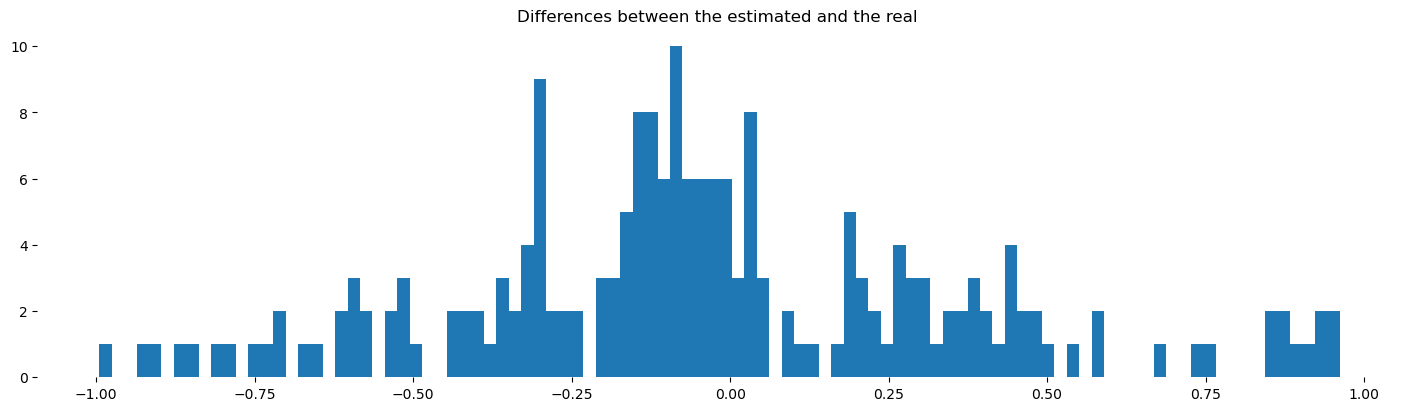

In [40]:
effect_exp = scipy.special.expit(simple_model1_idata.posterior.country_effect).mean(dim =["chain", "draw"])

summary_df = az.summary(simple_model1_idata )["mean"]

differences  = ( effect_exp - np.array(model_df_1.groupby("ISO").is_disaster.mean()) )
plt.hist(differences, bins = 100)
plt.title("Differences between the estimated and the real ");

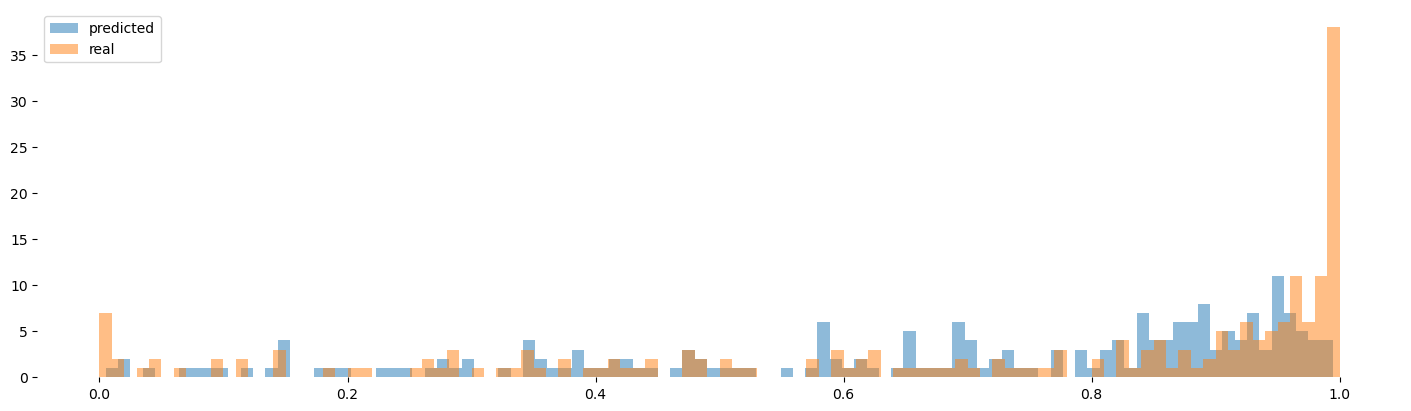

In [41]:
plt.hist(scipy.special.expit(simple_model1_idata.posterior.country_effect).mean(dim =["chain", "draw"]),
         bins = 100, alpha=0.5 , label = "predicted")

plt.hist(np.array(model_df_1.groupby("ISO").is_disaster.mean()), bins = 100,  alpha=0.5, label = "real");

plt.legend();

# Logistic regression with distance features

In [42]:
#Delimiting data set
model_list_2 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline', 'is_island',
                "lat", "long" ]

features_2 = ['log_distance_to_river', 'log_distance_to_coastline']

model_df_2 = merged_df5[model_list_2].dropna()

In [43]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_2["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_2["ISO"]) 
obs_idx = model_df_2.index

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_2.set_index(['lat', 'long']).index, 'lat_long')

#Set coords
coords_2 = {"is_disaster" : is_disaster,
            "obs_idx": obs_idx,
             "ISO": ISO,
             "feature": features_2,
             "lat": model_df_2["lat"],
                "long": model_df_2["long"],
           }


In [44]:
with pm.Model(coords=coords_2) as model_distance2:
    #Declare data
    X, Y= add_data(features= features_2 ,  target = "is_disaster", df =  model_df_2, )
    is_island = pm.Data("is_island",  model_df_2["is_island"].astype(bool), dims = ["obs_idx"] )
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [ 1, 1]
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("is_island_beta", mu = 1, sigma = 1)

    #Model mu
    p = country_effect[ISO_idx] + (X * beta).sum(axis=1) + (is_island * is_island_beta)

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [45]:
#Sampling
with model_distance2:
    model_distance2_idata =sample_or_load(
            fp="model_distance2d",
            resample= False,
            sample_kwargs={
                "nuts_sampler": 'numpyro',
                "chains": 8,
                "draws": 1000,
            })

    model_distance2_idata = model_distance2_idata.assign_coords({"lat": model_df_2["lat"],
                                                                 "long": model_df_2["long"]})

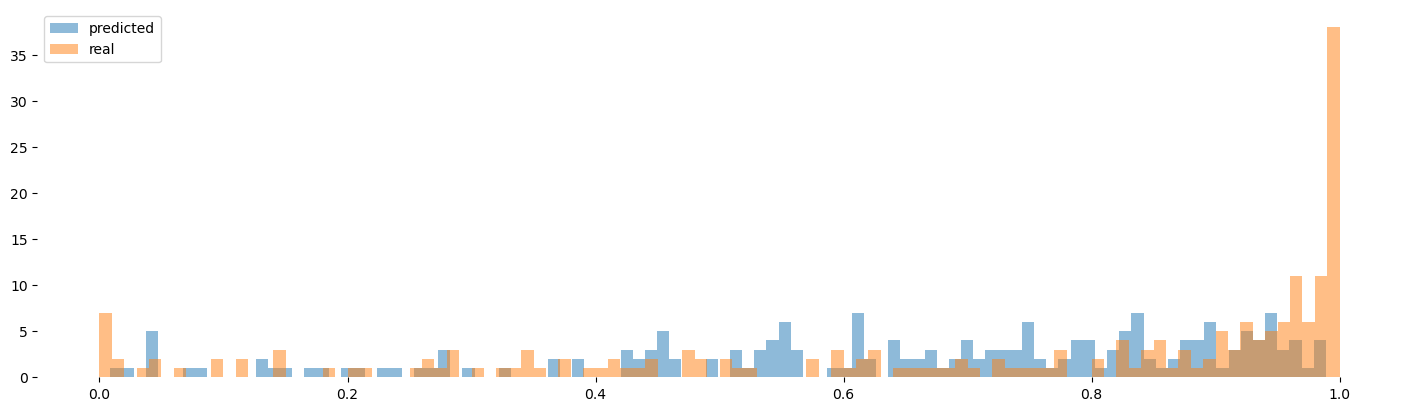

In [46]:
plt.hist(scipy.special.expit(model_distance2_idata.posterior.country_effect).mean(dim =["chain", "draw"]),
         bins = 100, alpha=0.5 , label = "predicted")

plt.hist( np.array(model_df_1.groupby("ISO").is_disaster.mean()), bins = 100,  alpha=0.5, label = "real");

plt.legend();

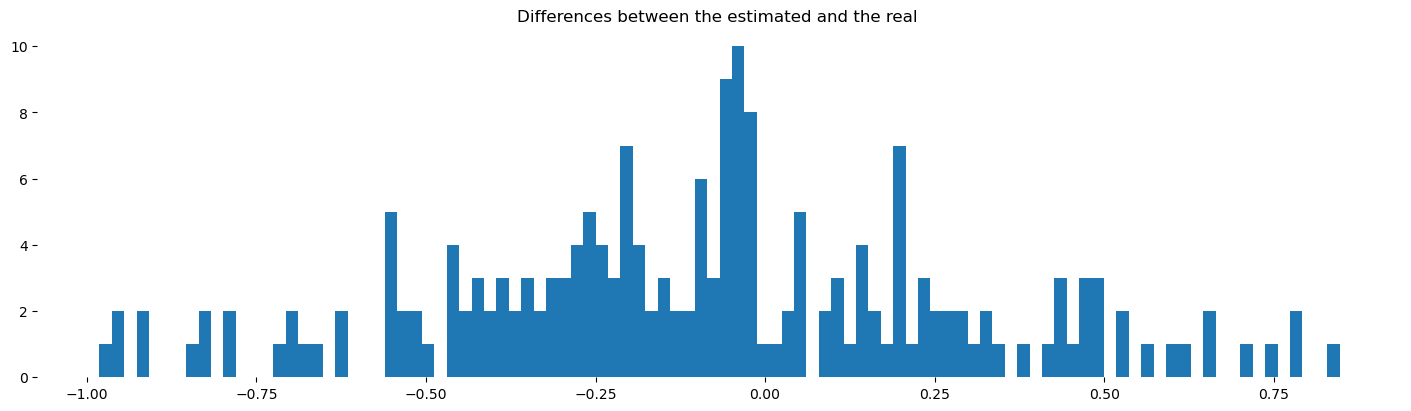

In [47]:
effect_exp = scipy.special.expit(model_distance2_idata.posterior.country_effect).mean(dim =["chain", "draw"])

summary_df = az.summary(model_distance2_idata )["mean"]

differences  = ( effect_exp - np.array(model_df_2.groupby("ISO").is_disaster.mean()) )
plt.hist(differences, bins = 100)
plt.title("Differences between the estimated and the real ");

In [48]:
az.summary(model_distance2_idata, ["~country_effect", "~country_effect_offset"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
beta[log_distance_to_river]     -0.385  0.015  -0.412   -0.355      0.000   
beta[log_distance_to_coastline] -0.878  0.018  -0.911   -0.844      0.000   
is_island_beta                   1.496  0.168   1.173    1.801      0.004   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
beta[log_distance_to_river]        0.000    7740.0    6699.0    1.0  
beta[log_distance_to_coastline]    0.000    6890.0    6881.0    1.0  
is_island_beta                     0.003    1507.0    3126.0    1.0

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


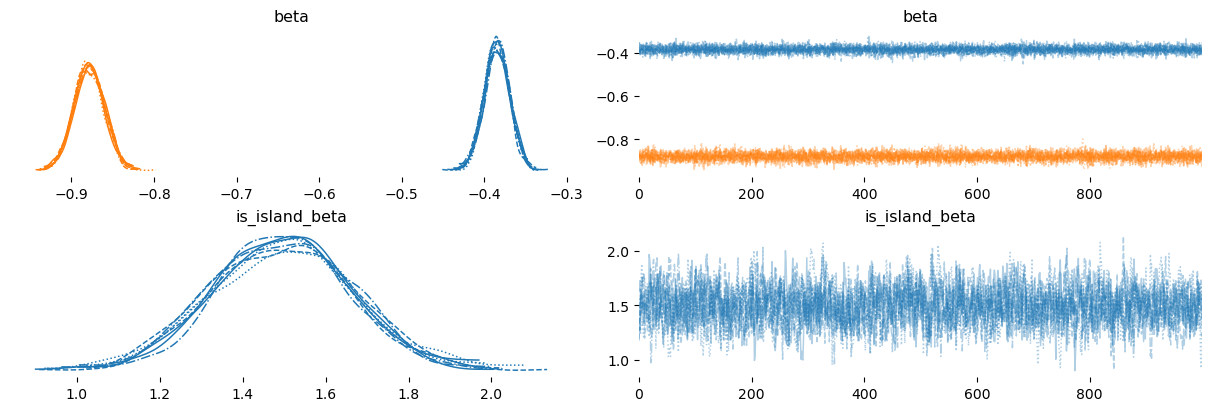

In [49]:
az.plot_trace(model_distance2_idata, var_names =  ["~country_effect", "~country_effect_offset"]);

In [50]:
predictions_df_2 = model_distance2_idata.posterior_predictive.mean(dim=['chain', 'draw'])["y_hat"].to_dataframe()
lat_long = model_df_2[["lat", "long", "ISO"]].reset_index().rename(columns = {"index": "obs_idx"}).set_index("obs_idx")

predictions_df_2 = pd.merge(predictions_df_2, lat_long, left_index=True, right_index= True, how = "left" )

#Tranform lat and long to geometry data
predictions_geo_2 = gpd.GeoDataFrame(
                predictions_df_2, geometry=gpd.points_from_xy(predictions_df_2["long"], predictions_df_2["lat"]), crs="EPSG:4326"
            )

## Laos predictions


In [51]:
#Sample predictions for Laos
with pm.Model(coords=coords_2) as model_distance2_plot:
    laos_lat = laos_points["lat"]
    laos_long = laos_points["lon"]
    X = laos_points[['log_distance_to_river', 'log_distance_to_coastline']]
    laos_is_island = laos_points["is_island"]
    
    #country_effect = pm.Flat("country_effect", dims = ["ISO"])
    beta = pm.Flat("beta", dims=["feature"])
    is_island_beta = pm.Flat("is_island_beta")
    country_effect = pm.Flat("country_effect", dims=["ISO"])
    

    point_prediction = pm.Deterministic("point_prediction", country_effect[151] + (beta[0] * X["log_distance_to_river"] ) +
                                        (beta[1] * X["log_distance_to_coastline"] )+ ( is_island_beta * laos_is_island) )

    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_distance2_plot_idata = pm.sample_posterior_predictive(
        model_distance2_idata,
        var_names=[
            "point_probability",
        ]
    )

Sampling: []


Output()

In [52]:
#Store df of predictions
model_distance2_predictions = (model_distance2_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                               ["point_probability"]
                               .to_dataframe())

#Merge predictions with Laos points
model_distance2_predictions = pd.merge(model_distance2_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

#Transform into geo Data Frame
model_distance2_predictions_geo = gpd.GeoDataFrame(
                model_distance2_predictions,
    geometry=gpd.points_from_xy(model_distance2_predictions["lon"], model_distance2_predictions["lat"]), crs="EPSG:4326"
            )

In [53]:
#Create the geodata set for Laos disasters
laos_disasters = model_df_2.query('ISO == "LAO" & is_disaster == 1')

laos_disasters_geo = gpd.GeoDataFrame(
                laos_disasters,
    geometry=gpd.points_from_xy(laos_disasters["long"], laos_disasters["lat"]), crs="EPSG:4326"
            )

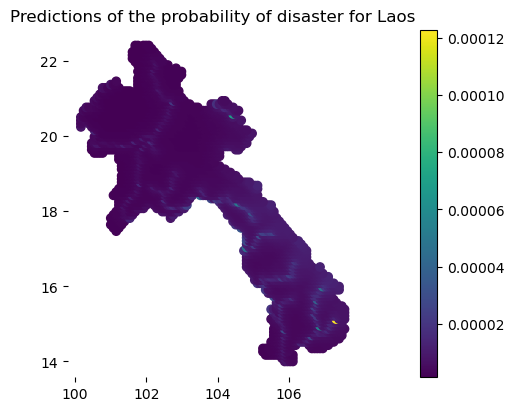

In [54]:
#Plot the predictions
fig, ax = plt.subplots()
model_distance2_predictions_geo.plot("point_probability",legend=True, ax=ax)
plt.title("Predictions of the probability of disaster for Laos", );

''

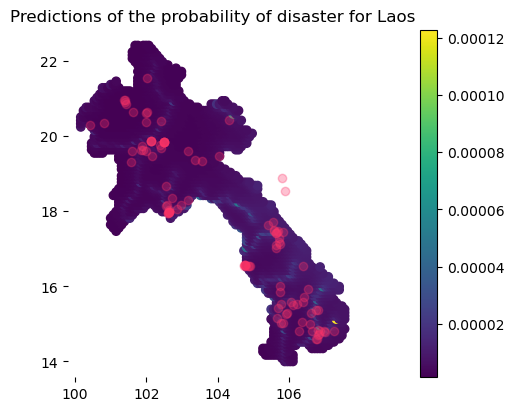

In [55]:
#Plot predictions with actual disasters
fig, ax = plt.subplots()
model_distance2_predictions_geo.plot("point_probability",legend=True, ax=ax)

laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "#fc3468")
plt.title("Predictions of the probability of disaster for Laos", )
;


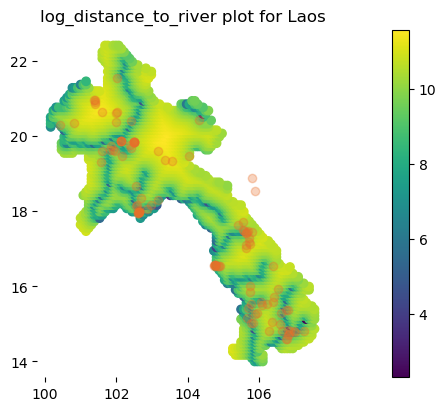

In [56]:
#Plot distance to river with actual disasters
fig, ax = plt.subplots()
model_distance2_predictions_geo.plot("log_distance_to_river",legend=True, ax=ax)

laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "#e8702a")
plt.title("log_distance_to_river plot for Laos", );

# Logistic regression with distance and country features

In [57]:
#Delimiting data set
model_list_3 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline', 'is_island',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
               'log_gdp_per_cap', 'log_gdp_per_cap_squared', "lat", "long"]

features_3 = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared']

model_df_3 = merged_df5[model_list_3].dropna()

In [58]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_3["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_3["ISO"]) 
obs_idx = model_df_3.index

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_3.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_3 = {"is_disaster" : is_disaster,
            "obs_idx": obs_idx,
            "ISO": ISO,
            "feature": features_3,
            "lat": model_df_3["lat"],
            "long": model_df_3["long"],}


In [59]:
with pm.Model(coords=coords_3) as model_distance3:
    #Declare data
    X, Y= add_data(features= features_3 ,  target = "is_disaster", df =  model_df_3, )
    is_island = pm.Data("is_island",  model_df_3["is_island"].astype(bool), dims = ["obs_idx"] )
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("is_island_beta", mu = 1, sigma = 1)

    #Model mu
    p = country_effect[ISO_idx] + (X * beta).sum(axis=1) + (is_island * is_island_beta)

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [60]:
#Sampling
with model_distance3:
    model_distance3_idata =sample_or_load(
            fp="model_distance3d",
            resample= False,
            sample_kwargs={
                "nuts_sampler": 'numpyro',
                "chains": 8,
                "draws": 1000,
            })

    model_distance3_idata = model_distance3_idata.assign_coords(xr_idx)

In [61]:
az.summary(model_distance3_idata, ["~country_effect", "~country_effect_offset"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  \
beta[log_distance_to_river]          -0.389  0.017  -0.420   -0.355   
beta[log_distance_to_coastline]      -0.786  0.020  -0.824   -0.749   
beta[Population]                     -0.584  0.077  -0.734   -0.447   
beta[co2]                             0.830  0.022   0.790    0.871   
beta[precip_deviation]                0.149  0.022   0.107    0.190   
beta[dev_ocean_temp]                  0.245  0.014   0.218    0.272   
beta[log_population_density]          0.868  0.081   0.712    1.020   
beta[log_population_density_squared]  0.868  0.082   0.716    1.023   
beta[log_gdp_per_cap]                -0.615  0.079  -0.760   -0.465   
beta[log_gdp_per_cap_squared]        -0.616  0.080  -0.765   -0.468   
is_island_beta                        1.298  0.281   0.768    1.818   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[log_distance_to_river]               0.000    0.000    7812.0    6817.0   
beta[log_distance_to_coastline]           0.000    0.000    7035.0    5798.0   
beta[Population]                          0.002    0.001    2232.0    3573.0   
beta[co2]                                 0.000    0.000    2317.0    4991.0   
beta[precip_deviation]                    0.000    0.000    8358.0    6142.0   
beta[dev_ocean_temp]                      0.000    0.000    7711.0    6323.0   
beta[log_population_density]              0.002    0.001    2660.0    4477.0   
beta[log_population_density_squared]      0.001    0.001    3014.0    4912.0   
beta[log_gdp_per_cap]                     0.002    0.001    2558.0    4902.0   
beta[log_gdp_per_cap_squared]             0.002    0.001    1734.0    4331.0   
is_island_beta                            0.007    0.005    1525.0    2692.0   

                                      r_hat  
beta[log_distance_to_river]             1.0  
beta[log_distance_to_coastline]         1.0  
beta[Population]                        1.0  
beta[co2]                               1.0  
beta[precip_deviation]                  1.0  
beta[dev_ocean_temp]                    1.0  
beta[log_population_density]            1.0  
beta[log_population_density_squared]    1.0  
beta[log_gdp_per_cap]                   1.0  
beta[log_gdp_per_cap_squared]           1.0  
is_island_beta                          1.0

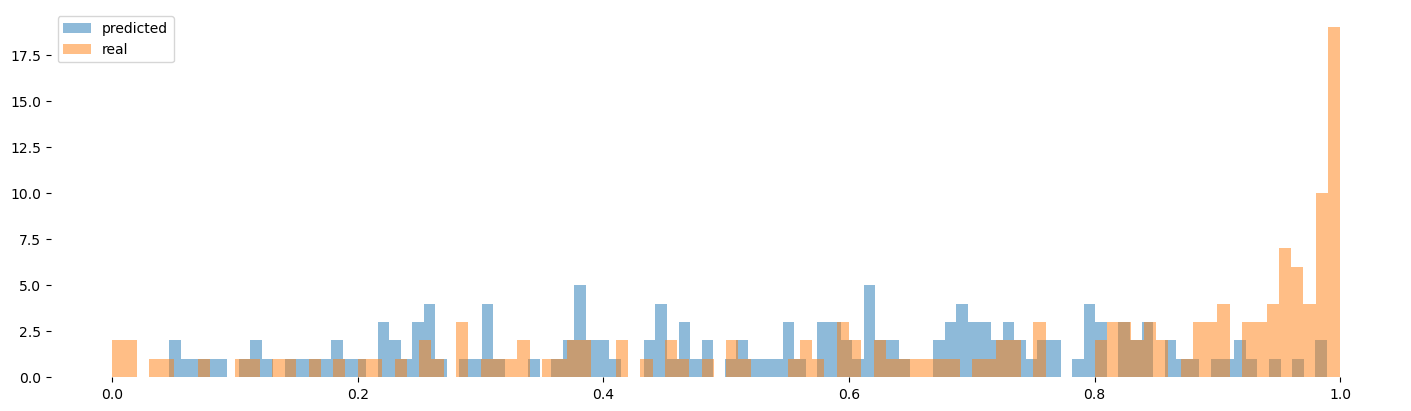

In [62]:
plt.hist(scipy.special.expit(model_distance3_idata.posterior.country_effect).mean(dim =["chain", "draw"]),
         bins = 100, alpha=0.5 , label = "predicted")

plt.hist( np.array(model_df_3.groupby("ISO").is_disaster.mean()), bins = 100,  alpha=0.5, label = "real");

plt.legend();

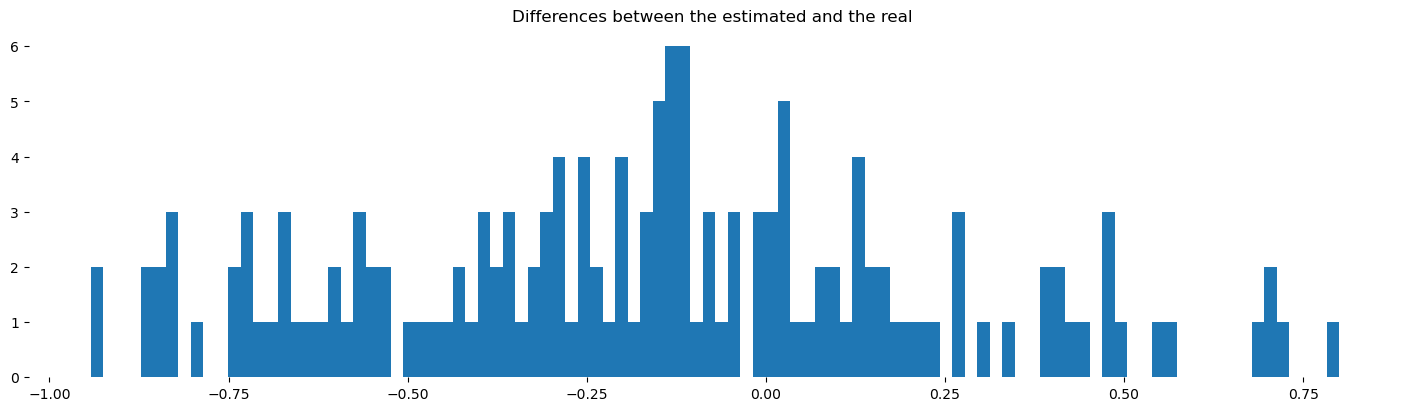

In [63]:
effect_exp = scipy.special.expit(model_distance3_idata.posterior.country_effect).mean(dim =["chain", "draw"])

summary_df = az.summary(model_distance3_idata )["mean"]

differences  = ( effect_exp - np.array(model_df_3.groupby("ISO").is_disaster.mean()) )
plt.hist(differences, bins = 100)
plt.title("Differences between the estimated and the real ");

## Laos predictions

In [64]:
#Sample predictions for Laos


# with pm.Model(coords=coords_3) as model_distance3_plot:
#     laos_lat = laos_points["lat"]
#     laos_long = laos_points["lon"]
#     X = laos_points[['log_distance_to_river', 'log_distance_to_coastline']]
#     laos_is_island = laos_points["is_island"]
    
#     #country_effect = pm.Flat("country_effect", dims = ["ISO"])
#     beta = pm.Flat("beta", dims=["feature"])
#     is_island_beta = pm.Flat("is_island_beta")
#     country_effect = pm.Flat("country_effect", dims=["ISO"])
    

#     point_prediction = pm.Deterministic("point_prediction", country_effect[ISO_idx] + (beta @ X) + ( is_island_beta * laos_is_island) )

#     point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

#     model_distance3_plot_idata = pm.sample_posterior_predictive(
#         model_distance3_idata,
#         var_names=[
#             "point_probability",
#         ]
#     )

# Losgistic regression with HSGP component

In [36]:
#Delimiting data set
model_list_4 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline', 'is_island',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
               'log_gdp_per_cap', 'log_gdp_per_cap_squared', "lat", "long" ]

features_4 = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared']

model_df_4 = merged_df5[model_list_4].dropna()

In [37]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_4["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_4["ISO"]) 
obs_idx = model_df_4.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_4.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_4 = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_4,
        "gp_feature":gp_features }


## 10% sample

In [66]:
#Sample
model_df_4_sample = model_df_4.groupby(["ISO", "is_disaster"]).sample( frac= 0.1) 

#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_4_sample["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_4_sample["ISO"]) 
obs_idx = model_df_4_sample.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_4_sample.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_4_sample = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_4,
        "gp_feature":gp_features }


In [296]:
with pm.Model(coords=coords_4_sample) as model_distance4_sample:
    #Declare data
    X, Y= add_data(features= features_4 ,  target = "is_disaster", df =  model_df_4_sample, )
    is_island = pm.Data("is_island",  model_df_4_sample["is_island"].astype(bool), dims = ["obs_idx"] )
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", model_df_4_sample[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 30, 30, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    #Model mu
    p = country_effect[ISO_idx] + (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [297]:
#Sampling
with model_distance4_sample:
    model_distance4_idata =sample_or_load(
            fp="model_distance4_sample",
            resample= False,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "draws": 1000,
            })

    model_distance4_idata = model_distance4_idata.assign_coords(xr_idx)

In [294]:
#Rename the is_island variable 
model_distance4_idata = model_distance4_idata.rename({"'is_island'": "is_island_beta"})

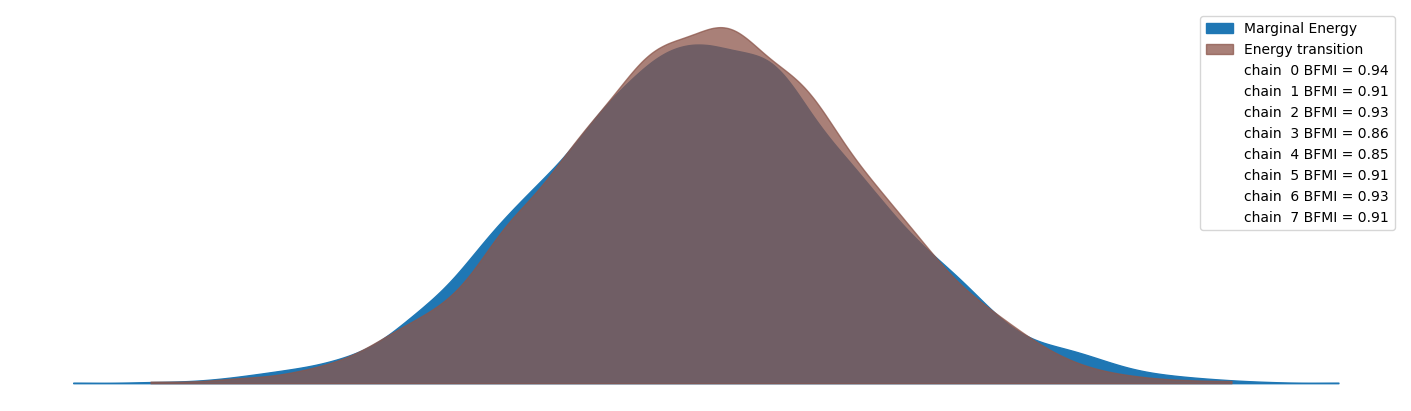

In [290]:
az.plot_energy(model_distance4_idata);

In [68]:
az.summary(model_distance4_idata, var_names=[ 'beta', "'is_island'", 'eta', 'ell'])

mean     sd  hdi_3%  hdi_97%  \
beta[log_distance_to_river]           -0.131  0.055  -0.234   -0.027   
beta[log_distance_to_coastline]       -0.549  0.067  -0.677   -0.429   
beta[Population]                      -0.124  0.091  -0.304    0.036   
beta[co2]                              0.684  0.050   0.594    0.783   
beta[precip_deviation]                 0.131  0.058   0.022    0.242   
beta[dev_ocean_temp]                   0.180  0.042   0.103    0.260   
beta[log_population_density]           0.267  0.093   0.085    0.435   
beta[log_population_density_squared]   0.266  0.091   0.099    0.437   
beta[log_gdp_per_cap]                 -0.158  0.093  -0.324    0.024   
beta[log_gdp_per_cap_squared]         -0.158  0.092  -0.324    0.020   
'is_island'                            1.535  0.559   0.520    2.606   
eta                                    2.861  0.466   2.031    3.709   
ell[lat]                              12.335  1.840   9.016   15.845   
ell[long]                             26.217  5.177  16.487   35.663   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[log_distance_to_river]               0.001    0.000    9894.0    5812.0   
beta[log_distance_to_coastline]           0.001    0.001    7145.0    6029.0   
beta[Population]                          0.001    0.001    4509.0    4865.0   
beta[co2]                                 0.001    0.000    8629.0    6399.0   
beta[precip_deviation]                    0.001    0.000   10606.0    6051.0   
beta[dev_ocean_temp]                      0.000    0.000   10614.0    6117.0   
beta[log_population_density]              0.001    0.001    6931.0    4875.0   
beta[log_population_density_squared]      0.001    0.001    6880.0    5817.0   
beta[log_gdp_per_cap]                     0.001    0.001    5729.0    5568.0   
beta[log_gdp_per_cap_squared]             0.001    0.001    6006.0    5091.0   
'is_island'                               0.011    0.008    2565.0    4344.0   
eta                                       0.017    0.012     749.0    1782.0   
ell[lat]                                  0.059    0.042     953.0    2173.0   
ell[long]                                 0.197    0.139     685.0    1322.0   

                                      r_hat  
beta[log_distance_to_river]            1.00  
beta[log_distance_to_coastline]        1.00  
beta[Population]                       1.00  
beta[co2]                              1.00  
beta[precip_deviation]                 1.00  
beta[dev_ocean_temp]                   1.00  
beta[log_population_density]           1.00  
beta[log_population_density_squared]   1.00  
beta[log_gdp_per_cap]                  1.00  
beta[log_gdp_per_cap_squared]          1.00  
'is_island'                            1.00  
eta                                    1.01  
ell[lat]                               1.01  
ell[long]                              1.02

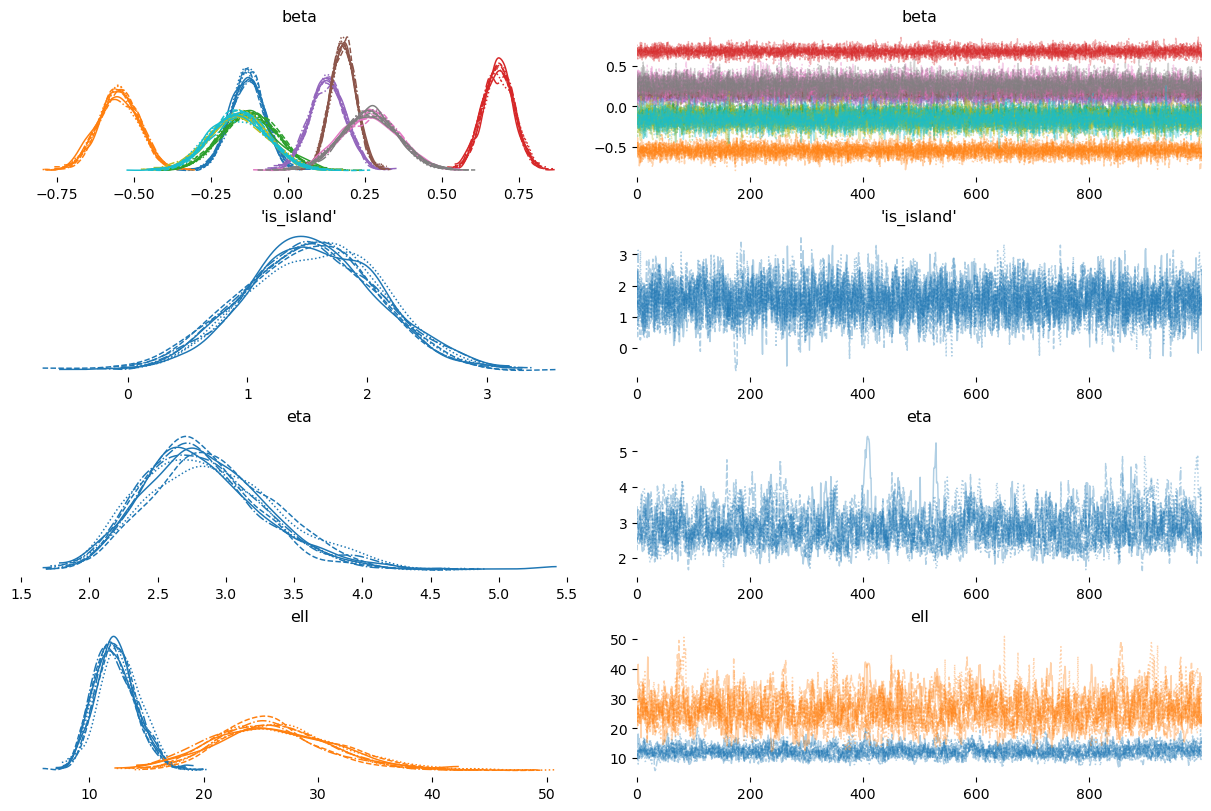

In [70]:
az.plot_trace(model_distance4_idata, var_names=[ 'beta', "'is_island'", 'eta', 'ell']);

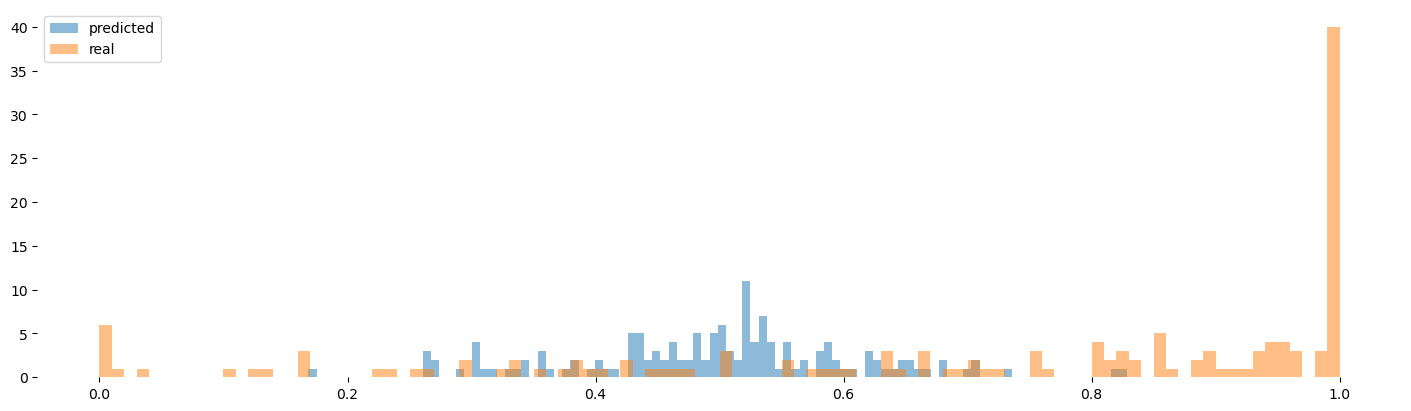

In [77]:
plt.hist(scipy.special.expit(model_distance4_idata.posterior.country_effect).mean(dim =["chain", "draw"]),
         bins = 100, alpha=0.5 , label = "predicted")

plt.hist( np.array(model_df_4_sample.groupby("ISO").is_disaster.mean()), bins = 100,  alpha=0.5, label = "real");

plt.legend();

In [ ]:
effect_exp = scipy.special.expit(model_distance4_idata.posterior.country_effect).mean(dim =["chain", "draw"])

summary_df = az.summary(model_distance4_idata )["mean"]

differences  = ( effect_exp - np.array(model_df_4_sample.groupby("ISO").is_disaster.mean()) )
plt.hist(differences, bins = 100)
plt.title("Differences between the estimated and the real ");

### Laos prediction

In [298]:
grid_2d = np.column_stack([x.ravel() for x in np.meshgrid(laos_points["lat"], laos_points["lon"])])

In [ ]:
#HP component
grid_2d = np.column_stack([x.ravel() for x in np.meshgrid(laos_points["lat"], laos_points["lon"])])

with pm.Model(coords=coords_4_sample) as GP_plot_sample:
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=grid_2d)
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))

    GP_plot_sample_idata = pm.sample_posterior_predictive(
        model_distance4_idata, var_names=["f_plot"]
    )

## 100% Sample m=15

In [38]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_4["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_4["ISO"]) 
obs_idx = model_df_4.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_4.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_4_sample = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_4,
        "gp_feature":gp_features }


In [39]:
with pm.Model(coords=coords_4_sample) as model_distance4:
    #Declare data
    X, Y= add_data(features= features_4 ,  target = "is_disaster", df =  model_df_4, )
    is_island = pm.Data("is_island",  model_df_4["is_island"].astype(bool), dims = ["obs_idx"] )
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", model_df_4[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    #Model mu
    p = country_effect[ISO_idx] + (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [ ]:
#Compile and sample
compiled_model = nutpie.compile_pymc_model(model_distance4, )
model_distance4_idata = nutpie.sample(compiled_model)

In [ ]:
#Sampling
with model_distance4:
    model_distance4_idata =sample_or_load(
            fp="model_distance4",
            resample= False,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "draws": 1000,
            })

    model_distance4_idata = model_distance4_idata.assign_coords(xr_idx)

In [294]:
#Rename the is_island variable 
model_distance4_10_sample_2_idata = model_distance4_10_sample_2_idata.rename({"'is_island'": "is_island_beta"})

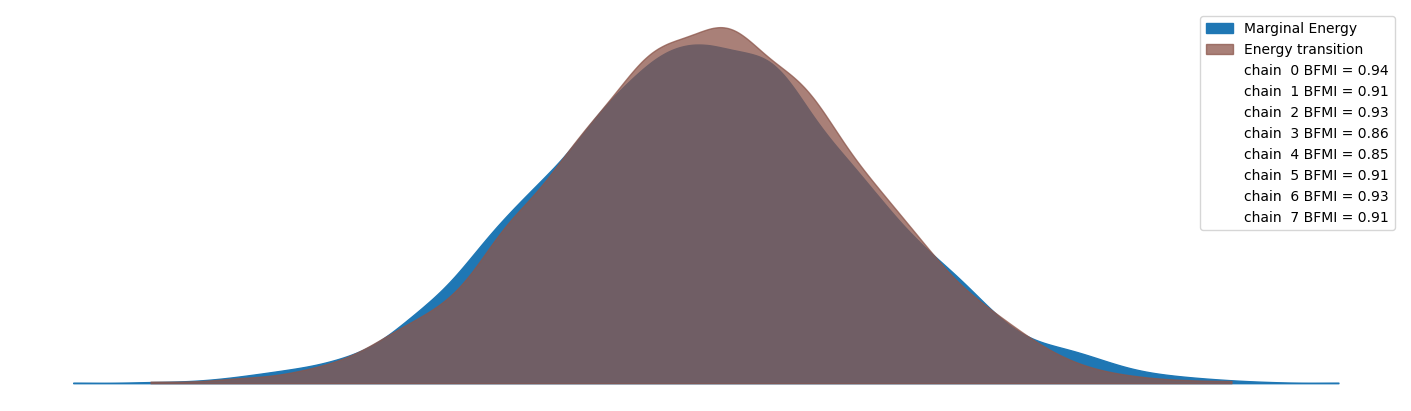

In [290]:
az.plot_energy(model_distance4_10_sample_2_idata);

In [68]:
az.summary(model_distance4_10_sample_2_idata, var_names=[ 'beta', "'is_island'", 'eta', 'ell'])

mean     sd  hdi_3%  hdi_97%  \
beta[log_distance_to_river]           -0.131  0.055  -0.234   -0.027   
beta[log_distance_to_coastline]       -0.549  0.067  -0.677   -0.429   
beta[Population]                      -0.124  0.091  -0.304    0.036   
beta[co2]                              0.684  0.050   0.594    0.783   
beta[precip_deviation]                 0.131  0.058   0.022    0.242   
beta[dev_ocean_temp]                   0.180  0.042   0.103    0.260   
beta[log_population_density]           0.267  0.093   0.085    0.435   
beta[log_population_density_squared]   0.266  0.091   0.099    0.437   
beta[log_gdp_per_cap]                 -0.158  0.093  -0.324    0.024   
beta[log_gdp_per_cap_squared]         -0.158  0.092  -0.324    0.020   
'is_island'                            1.535  0.559   0.520    2.606   
eta                                    2.861  0.466   2.031    3.709   
ell[lat]                              12.335  1.840   9.016   15.845   
ell[long]                             26.217  5.177  16.487   35.663   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[log_distance_to_river]               0.001    0.000    9894.0    5812.0   
beta[log_distance_to_coastline]           0.001    0.001    7145.0    6029.0   
beta[Population]                          0.001    0.001    4509.0    4865.0   
beta[co2]                                 0.001    0.000    8629.0    6399.0   
beta[precip_deviation]                    0.001    0.000   10606.0    6051.0   
beta[dev_ocean_temp]                      0.000    0.000   10614.0    6117.0   
beta[log_population_density]              0.001    0.001    6931.0    4875.0   
beta[log_population_density_squared]      0.001    0.001    6880.0    5817.0   
beta[log_gdp_per_cap]                     0.001    0.001    5729.0    5568.0   
beta[log_gdp_per_cap_squared]             0.001    0.001    6006.0    5091.0   
'is_island'                               0.011    0.008    2565.0    4344.0   
eta                                       0.017    0.012     749.0    1782.0   
ell[lat]                                  0.059    0.042     953.0    2173.0   
ell[long]                                 0.197    0.139     685.0    1322.0   

                                      r_hat  
beta[log_distance_to_river]            1.00  
beta[log_distance_to_coastline]        1.00  
beta[Population]                       1.00  
beta[co2]                              1.00  
beta[precip_deviation]                 1.00  
beta[dev_ocean_temp]                   1.00  
beta[log_population_density]           1.00  
beta[log_population_density_squared]   1.00  
beta[log_gdp_per_cap]                  1.00  
beta[log_gdp_per_cap_squared]          1.00  
'is_island'                            1.00  
eta                                    1.01  
ell[lat]                               1.01  
ell[long]                              1.02

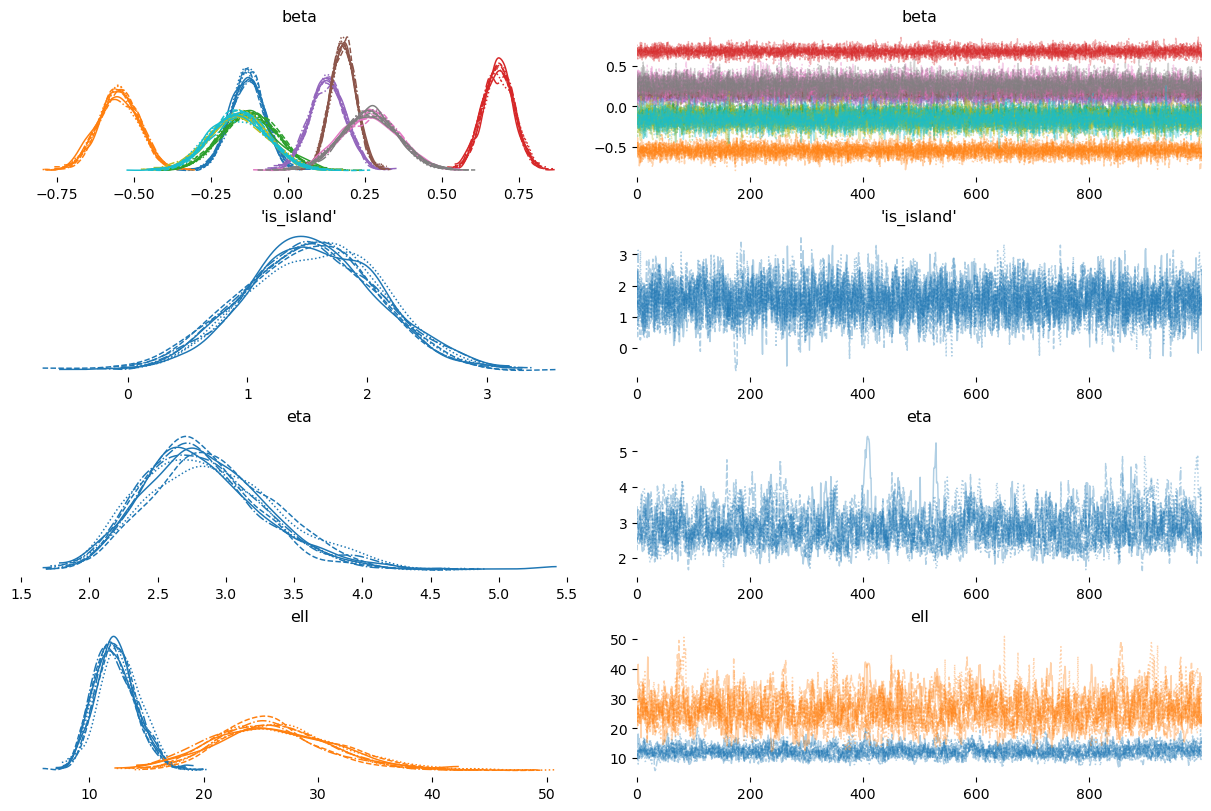

In [70]:
az.plot_trace(model_distance4_10_sample_2_idata, var_names=[ 'beta', "'is_island'", 'eta', 'ell']);

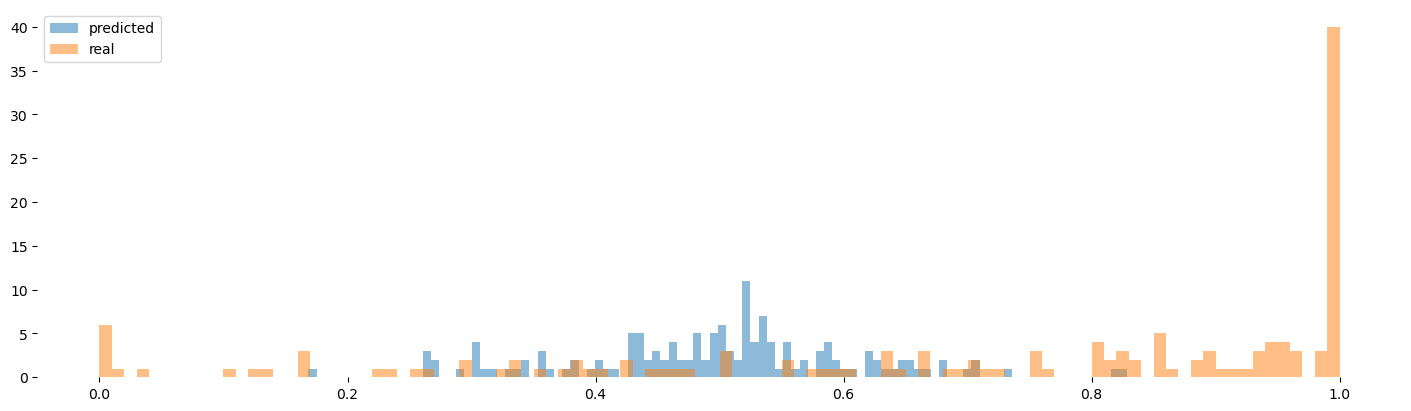

In [77]:
plt.hist(scipy.special.expit(model_distance4_10_sample_2_idata.posterior.country_effect).mean(dim =["chain", "draw"]),
         bins = 100, alpha=0.5 , label = "predicted")

plt.hist( np.array(model_df_4_sample.groupby("ISO").is_disaster.mean()), bins = 100,  alpha=0.5, label = "real");

plt.legend();

In [ ]:
effect_exp = scipy.special.expit(model_distance4_10_sample_2_idata.posterior.country_effect).mean(dim =["chain", "draw"])

summary_df = az.summary(model_distance4_10_sample_2_idata )["mean"]

differences  = ( effect_exp - np.array(model_df_4_sample.groupby("ISO").is_disaster.mean()) )
plt.hist(differences, bins = 100)
plt.title("Differences between the estimated and the real ");

### Laos prediction

In [ ]:
grid_2d = np.column_stack([x.ravel() for x in np.meshgrid(laos_points["lat"], laos_points["lon"])])

In [ ]:
#HP component
grid_2d = np.column_stack([x.ravel() for x in np.meshgrid(laos_points["lat"], laos_points["lon"])])

with pm.Model(coords=coords_4_sample) as GP_plot_10_sample_2_sample:
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=grid_2d)
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))

    GP_plot_10_sample_2_sample_idata = pm.sample_posterior_predictive(
        model_distance4_10_sample_2_idata, var_names=["f_plot"]
    )

In [52]:
#Store df of predictions
model_distance2_predictions = (GP_plot_10_sample_2_sample_idata.posterior_predictive.mean(dim=("chain", "draw"))
                               ["point_probability"]
                               .to_dataframe())

#Merge predictions with Laos points
model_distance2_predictions = pd.merge(model_distance2_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

#Transform into geo Data Frame
model_distance2_predictions_geo = gpd.GeoDataFrame(
                model_distance2_predictions,
    geometry=gpd.points_from_xy(model_distance2_predictions["lon"], model_distance2_predictions["lat"]), crs="EPSG:4326"
            )

In [53]:
#Create the geodata set for Laos disasters
laos_disasters = model_df_2.query('ISO == "LAO" & is_disaster == 1')

laos_disasters_geo = gpd.GeoDataFrame(
                laos_disasters,
    geometry=gpd.points_from_xy(laos_disasters["long"], laos_disasters["lat"]), crs="EPSG:4326"
            )

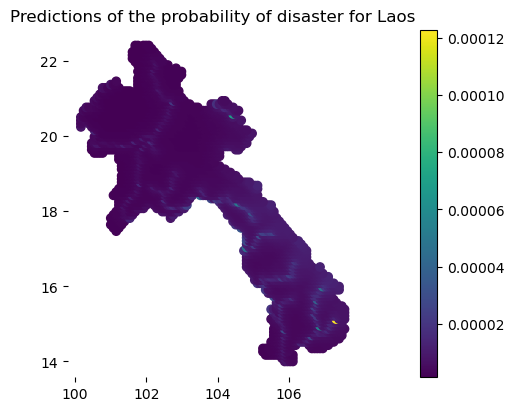

In [54]:
#Plot the predictions
fig, ax = plt.subplots()
model_distance2_predictions_geo.plot("point_probability",legend=True, ax=ax)
plt.title("Predictions of the probability of disaster for Laos", );

''

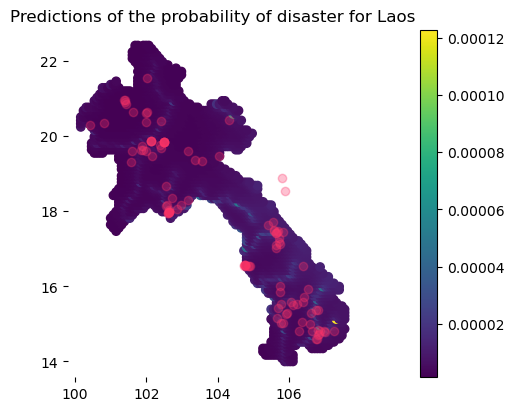

In [55]:
#Plot predictions with actual disasters
fig, ax = plt.subplots()
model_distance2_predictions_geo.plot("point_probability",legend=True, ax=ax)

laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "#fc3468")
plt.title("Predictions of the probability of disaster for Laos", )
;
